In [3]:
import torch
import torch.nn as nn
import librosa
import librosa.display
import os
import numpy as np
from IPython.display import Audio
from scipy import signal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import soundfile as sf

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.norm_1 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_2 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.1)
        self.feed_fwd_net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, x):
        attention_output, _ = self.mha(x, x, x)
        out = self.dropout_1(attention_output)
        out = self.norm_1(out + x)
        # 
        ffn_out = self.feed_fwd_net(out)
        ffn_out = self.dropout_2(ffn_out)
        out = self.norm_2(out + ffn_out)
        return out

class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, n_enc_blcks = 9, device = "cpu"):
        super(Encoder, self).__init__()
        self.mha_list = nn.ModuleList([
            EncoderBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(n_enc_blcks)
        ]).to(device)
    
    def forward(self, x):
        out = self.mha_list[0](x)
        for encoder_blck in self.mha_list:
            out = encoder_blck(out)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(DecoderBlock, self).__init__()
        self.mha_1 = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.mha_2 = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.norm_1 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_2 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_3 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.1)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.feed_fwd_net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x, encoded_x):
        attention_output, _ = self.mha_1(x, x, x)
        out = self.dropout_1(attention_output)
        out = self.norm_1(out + x)
        # 
        out_mha2, _ = self.mha_2(encoded_x, encoded_x, x)
        out_mha2 = self.dropout_2(out_mha2)
        out = self.norm_2(out_mha2 + out)
        # 
        ffn_out = self.feed_fwd_net(out)
        ffn_out = self.dropout_3(ffn_out)
        out = self.norm_3(ffn_out + out)
        return out

class Decoder(nn.Module):
    def __init__(self, embed_dim, num_heads, n_dec_blcks = 6, device = "cpu"):
        super(Decoder, self).__init__()
        self.decoder_list = nn.ModuleList([
            DecoderBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(n_dec_blcks)
        ]).to(device)

    def forward(self, x, encoded_x):
        for decoder_blck in self.decoder_list:
            x = decoder_blck(x, encoded_x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, embed_dim, num_heads, n_enc_blcks = 9, n_dec_blcks = 9, device = "cpu"):
        super(TransformerModel, self).__init__()
        self.encoder = Encoder(embed_dim=embed_dim, num_heads=num_heads, n_enc_blcks=n_enc_blcks, device = device)
        self.decoder = Decoder(embed_dim=embed_dim, num_heads=num_heads, n_dec_blcks=n_dec_blcks, device = device)
    
    def forward(self, x_src, x_trg):
        enc_out = self.encoder(x_src)
        dec_out = self.decoder(x_trg, enc_out)
        return dec_out


In [17]:
import librosa
import numpy as np
import torch
from scipy import signal
import copy

FRAME_SHIFT = 0.0125
FRAME_LENGTH = 0.05
SAMPLE_RATE = 16000
TOP_DB = 15
PREEMHPASIS = 0.97
N_FFT = 2048
MAX_DB = 100
HOP_LENGTH = int(SAMPLE_RATE*FRAME_SHIFT)
WIN_LENTGH = int(SAMPLE_RATE*FRAME_LENGTH)
N_MELS = 512
REF_DB = 20
N_GRIFFIN_LIM_ITER = 100
FRAME_SIZE = 1

def get_spectrograms(fpath):
    """
    Returns mel spect from wav file.
    """
    y, sr = librosa.load(fpath, sr=SAMPLE_RATE)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB)
    y = np.append(y[0], y[1:] - PREEMHPASIS * y[:-1])
    # stft
    linear = librosa.stft(y=y,
                          n_fft=N_FFT,
                          hop_length=HOP_LENGTH,
                          win_length=WIN_LENTGH)

    mag = np.abs(linear)
    # mel spectrogram
    mel_basis = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
    mel = np.dot(mel_basis, mag)
    # to decibel
    mel = 20 * np.log10(np.maximum(1e-5, mel))
    # normalize
    mel = np.clip((mel - REF_DB + MAX_DB) / MAX_DB, 1e-8, 1)
    mel = mel.astype(np.float32)

    return mel

def invert_spectrogram(spectrogram):
    '''
    spectrogram: [f, t]
    '''
    return librosa.istft(spectrogram, hop_length = HOP_LENGTH, win_length=WIN_LENTGH, window="hann")

def griffin_lim(spectrogram):
    X_best = copy.deepcopy(spectrogram)
    for i in range(N_GRIFFIN_LIM_ITER):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, n_fft = N_FFT, hop_length = HOP_LENGTH, win_length = WIN_LENTGH)
        phase = est / np.maximum(1e-8, np.abs(est))
        X_best = spectrogram * phase
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)
    return y

def _mel_to_linear_matrix(sr, n_fft, n_mels):
    m = librosa.filters.mel(sr = sr, n_fft = n_fft,n_mels = n_mels)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

def melspectrogram2wav(mel):
    # de-noramlize
    mel = (np.clip(mel, 0, 1) * MAX_DB) - MAX_DB + REF_DB

    # to amplitude
    mel = np.power(10.0, mel * 0.05)
    m = _mel_to_linear_matrix(SAMPLE_RATE, N_FFT, N_MELS)
    mag = np.dot(m, mel)
    # wav reconstruction
    wav = griffin_lim(mag)
    # de-preemphasis
    wav = signal.lfilter([1], [1, -PREEMHPASIS], wav)
    # trim
    wav, _ = librosa.effects.trim(wav)
    return wav.astype(np.float32)

def signal_pad(source, target_len = 128):
    if source.shape[-1] >= target_len:
        return source[:, :target_len]
    else:
        padding = np.zeros((source.shape[0], target_len - source.shape[1]), dtype = source.dtype) + 1e-5
        return np.concatenate([source, padding], axis = 1)

Input shape (512, 233)


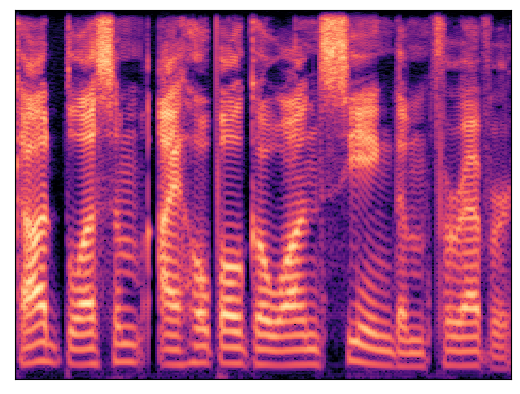

In [18]:
path = os.path.join("..", "spk_data", "speaker2", "arctic_a0006.wav")
mel = get_spectrograms(path)
print(f"Input shape {mel.shape}")
librosa.display.specshow(mel)
wav = melspectrogram2wav(mel)
Audio(wav, rate=16000)

In [19]:
CONFIG = {
    "model": {
        "embed_dim": 128,
        "num_heads": 4,
        "n_enc_blcks": 9,
        "n_dec_blcks": 6
    },
    "optimizer": {
        "lr": 1e-4,
        "beta1": 0.9,
        "beta2": 0.98,
        "weight_decay": 0.0001
    },
    "dataset_path": "../data/data",
    "data_loader": {
        "batch_size": 32
    },
    "n_iterations": 90000,
    "save_frequency": 15000
}

In [20]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = os.path.join("..", "models", "transformer-vc-mel", "model_save_iter_60000.ckpt")

model = TransformerModel(
    embed_dim = CONFIG["model"]["embed_dim"],
    num_heads = CONFIG["model"]["num_heads"],
    n_enc_blcks = CONFIG["model"]["n_enc_blcks"],
    n_dec_blcks = CONFIG["model"]["n_dec_blcks"],
    device = DEVICE
)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
test_tensor = torch.rand((1, 512, 128)).to(DEVICE)
with torch.no_grad():
    test = model(test_tensor, test_tensor)
test.shape

torch.Size([1, 512, 128])

In [30]:
source_speaker = "speaker2"
target_speaker = "speaker3"
source_sample = "arctic_a0010.wav"
target_sample = "arctic_a0011.wav"

SOURCE_SPEECH = os.path.join("..", "spk_data", source_speaker, source_sample)
TARGET_SPEECH = os.path.join("..", "spk_data", target_speaker, target_sample)

CONFIG_PATH = "config.json"

SRC_TARGET_CONVERSION = os.path.join("conversions", f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join("conversions", f"{target_speaker}_{source_speaker}_{target_sample}")

source_mel = get_spectrograms(SOURCE_SPEECH)
target_mel = get_spectrograms(TARGET_SPEECH)
source_mel = signal_pad(source_mel, target_len = 128)
target_mel = signal_pad(target_mel, target_len = 128)

mean = np.mean(np.hstack([source_mel, target_mel]))
std = np.std(np.hstack([source_mel, target_mel]))
source_mel = (source_mel - mean) / std
target_mel = (target_mel - mean) / std

source_speech, _ = librosa.load(SOURCE_SPEECH, sr=SAMPLE_RATE)
target_speech, _ = librosa.load(TARGET_SPEECH, sr=SAMPLE_RATE)
source_speech, _ = librosa.effects.trim(source_speech, top_db=TOP_DB)
target_speech, _ = librosa.effects.trim(target_speech, top_db=TOP_DB)

source_mel = torch.from_numpy(source_mel).unsqueeze(0).to(DEVICE)
target_mel = torch.from_numpy(target_mel).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    source_to_target = model(source_mel, target_mel)
    target_to_source = model(target_mel, source_mel)

source_to_target = (source_to_target.cpu().squeeze(0).numpy() * std) + mean
target_to_source = (target_to_source.cpu().squeeze(0).numpy() * std) + mean

source_to_target = melspectrogram2wav(source_to_target)
target_to_source = melspectrogram2wav(target_to_source)

In [32]:
Audio(source_to_target, rate = SAMPLE_RATE)

In [33]:
Audio(target_to_source, rate = SAMPLE_RATE)